In [2]:
import requests
from bs4 import BeautifulSoup
from datetime import datetime, timedelta
import time
import pandas as pd
import numpy as np
import random
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split, KFold
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# Section 1: Data Scraping & Wrangling Data

In [67]:
def daterange(start_date, end_date):
    for n in range(int((end_date - start_date).days) + 1):
        yield start_date + timedelta(days=n)
        
team_name_mapping = {
    "Cleveland": "CLE",
    "Charlotte": "CHO",
    "LA Lakers": "LAL",
    "New Orleans": "NOP",
    "Brooklyn": "BRK",
    "Oklahoma City": "OKC",
    "Milwaukee": "MIL",
    "Phoenix": "PHO",
    "New York": "NYK",
    "Atlanta": "ATL",
    "Boston": "BOS",
    "Chicago": "CHI",
    "Dallas": "DAL",
    "Denver": "DEN",
    "Detroit": "DET",
    "Golden State": "GSW",
    "Houston": "HOU",
    "Indiana": "IND",
    "LA Clippers": "LAC",
    "Memphis": "MEM",
    "Miami": "MIA",
    "Minnesota": "MIN",
    "Orlando": "ORL",
    "Philadelphia": "PHI",
    "Portland": "POR",
    "Sacramento": "SAC",
    "San Antonio": "SAS",
    "Toronto": "TOR",
    "Utah": "UTA",
    "Washington": "WAS",
}

def rate_limit(requests, per_minute, last_request_time):
    if len(requests) >= per_minute:
        time_since_oldest_request = datetime.now() - requests[0]
        if time_since_oldest_request < timedelta(minutes=1):
            sleep_time = (timedelta(minutes=1) - time_since_oldest_request).total_seconds() + 1
            print(f"Rate limit reached, sleeping for {sleep_time} seconds.")
            time.sleep(sleep_time)
        requests.pop(0)  
    requests.append(datetime.now())

request_times = []

def scrape_basic_box_score_stats(url, team_abbr):
    headers = {
        'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10.15; rv:86.0) Gecko/20100101 Firefox/86.0'
    }
    response = requests.get(url, headers=headers)
    rate_limit(request_times, 9, datetime.now())
    if response.status_code != 200:
        print(f"Failed to retrieve data from {url}")
        return {}
    
    soup = BeautifulSoup(response.content, 'html.parser')
    table_id = f'box-{team_abbr}-game-basic'
    table = soup.find('table', id=table_id)

    desired_stats = {
        'FGA': None,
        'FG_pct': None,
        'FTA': None,
        'FT_pct': None,
        'TRB': None,
        'fg3a': None,
        'fg3_pct': None,
        'TOV': None,
        'stl': None,
        'blk': None,
        'ast': None
    }

    if table:
        totals_row = table.find('tfoot').find('tr')
        if totals_row:
            for stat in desired_stats.keys():
                data_cell = totals_row.find('td', {'data-stat': stat.lower()})
                if data_cell:
                    desired_stats[stat] = data_cell.text.strip()

    return desired_stats

def scrape_general_game_info(date):
    headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/88.0.4324.190 Safari/537.36'
    }
    url = f"https://www.basketball-reference.com/boxscores/?month={date.month:02d}&day={date.day:02d}&year={date.year}"
    rate_limit(request_times, 9, datetime.now())  
    response = requests.get(url, headers=headers)
    if response.status_code != 200:
        print(f"Request failed for {url} with status code {response.status_code}")
        return []
    
    soup = BeautifulSoup(response.content, 'html.parser')
    games_info = []

    game_summaries = soup.find_all('div', class_='game_summary expanded nohover')
    for game_summary in game_summaries:
        teams = game_summary.find_all('tr', class_=['winner', 'loser'])
        box_score_link_tag = game_summary.find('p', class_='links').find('a', text='Box Score')
        if len(teams) == 2 and box_score_link_tag:
            box_score_link = "https://www.basketball-reference.com" + box_score_link_tag['href']
            team1, team1_score = teams[0].find('a').text.strip(), teams[0].find('td', class_='right').text.strip()
            team2, team2_score = teams[1].find('a').text.strip(), teams[1].find('td', class_='right').text.strip()
            game_info = {
                'date': date.strftime('%Y-%m-%d'),
                'team1': team1,
                'team1_score': team1_score,
                'team2': team2,
                'team2_score': team2_score,
                'box_score_link': box_score_link
            }
            
            game_info['team1_stats'] = scrape_basic_box_score_stats(box_score_link, team_name_mapping[team1])
            game_info['team2_stats'] = scrape_basic_box_score_stats(box_score_link, team_name_mapping[team2])
            games_info.append(game_info)
    return games_info

In [ ]:
#date range
start_date = datetime(2023, 11, 1)
end_date = datetime(2024, 4, 5)
total_days = (end_date - start_date).days + 1

#collecting all games data
all_games_data = []
for single_date in tqdm(daterange(start_date, end_date), total=total_days, desc = "Scraping Data"):
    games_info = scrape_general_game_info(single_date)
    all_games_data.extend(games_info)

expanded_games_data = []

for game in all_games_data:
    #extracting basic game info
    game_info = {
        'date': game['date'],
        'team1': game['team1'],
        'team1_score': game['team1_score'],
        'team2': game['team2'],
        'team2_score': game['team2_score'],
    }

    #extracting team1 stats and prefix with 'team1_'
    team1_stats = {f'team1_{k}': v for k, v in game['team1_stats'].items()}
    game_info.update(team1_stats)

    #extracting team2 stats and prefix with 'team2_'
    team2_stats = {f'team2_{k}': v for k, v in game['team2_stats'].items()}
    game_info.update(team2_stats)

    #adding the expanded game info to the new list
    expanded_games_data.append(game_info)

#converting to a DataFrame for analysis
df_games = pd.DataFrame(expanded_games_data)

print("Dataset with General Game Info and Basic Box Score Stats:")
print(df_games)

In [ ]:
#converted scraped data to csv to save it... so i don't spend another 5 hours data scraping

df_games.to_csv('br.csv', index = False)

In [68]:
br_df = pd.read_csv('br.csv')
print(br_df)

           date        team1  team1_score         team2  team2_score  \
0     11/1/2023   Washington          121       Atlanta          130   
1     11/1/2023      Indiana          104        Boston          155   
2     11/1/2023      Chicago          105        Dallas          114   
3     11/1/2023     Portland          110       Detroit          101   
4     11/1/2023   Sacramento          101  Golden State          102   
...         ...          ...          ...           ...          ...   
1098   4/5/2024      Detroit           90       Memphis          108   
1099   4/5/2024      Toronto          117     Milwaukee          111   
1100   4/5/2024  San Antonio          111   New Orleans          109   
1101   4/5/2024    Minnesota           87       Phoenix           97   
1102   4/5/2024     Portland          108    Washington          102   

      team1_FGA  team1_FG_pct  team1_FTA  team1_FT_pct  team1_TRB  ...  \
0           101         0.505         14         0.643       

In [69]:
unique_teams = pd.unique(br_df[['team1', 'team2']].values.ravel('K'))
#mapped each team to a unique integer
team_to_id = {team: i for i, team in enumerate(unique_teams)}
print(team_to_id)
br_df['Home_Team_ID'] = br_df['team2'].map(team_to_id) # home team is team 2
br_df['Away_Team_ID'] = br_df['team1'].map(team_to_id) # away team is team 1
#added win column
br_df['HomeWin'] = (br_df['team2_score'] > br_df['team1_score']).astype(int) #astype coverts boolean to integer 0 and 1

br_df['date'] = pd.to_datetime(br_df['date'])
br_df['month'] = (br_df['date'].dt.month - 11) % 12
print(br_df)


{'Washington': 0, 'Indiana': 1, 'Chicago': 2, 'Portland': 3, 'Sacramento': 4, 'Charlotte': 5, 'LA Clippers': 6, 'Brooklyn': 7, 'Denver': 8, 'Cleveland': 9, 'New Orleans': 10, 'Milwaukee': 11, 'Memphis': 12, 'Detroit': 13, 'Toronto': 14, 'San Antonio': 15, 'Orlando': 16, 'Dallas': 17, 'New York': 18, 'Golden State': 19, 'Boston': 20, 'Utah': 21, 'Atlanta': 22, 'LA Lakers': 23, 'Phoenix': 24, 'Miami': 25, 'Philadelphia': 26, 'Oklahoma City': 27, 'Minnesota': 28, 'Houston': 29}
           date        team1  team1_score         team2  team2_score  \
0    2023-11-01   Washington          121       Atlanta          130   
1    2023-11-01      Indiana          104        Boston          155   
2    2023-11-01      Chicago          105        Dallas          114   
3    2023-11-01     Portland          110       Detroit          101   
4    2023-11-01   Sacramento          101  Golden State          102   
...         ...          ...          ...           ...          ...   
1098 2024-04-05 

In [ ]:
#I saved the new 31 column version of dataframe
br_df.to_csv('br31.csv', index = False)

# Section 2: Predicting Wins with BR31 Dataframe

In [70]:
home_team = torch.tensor(br_df['Home_Team_ID'], dtype=torch.long)
away_team = torch.tensor(br_df['Away_Team_ID'], dtype=torch.long)
num_classes = 30 
home_teams_ohe = F.one_hot(home_team, num_classes=num_classes)
away_teams_ohe = F.one_hot(away_team, num_classes=num_classes)
date_stuff = torch.tensor(br_df['month'], dtype=torch.long)

months_ohe = F.one_hot(date_stuff, num_classes = 6)

x_ohe_tensor = torch.cat((home_teams_ohe, away_teams_ohe), dim=1)

numeric_data = br_df.drop(['date', 'month', 'Home_Team_ID', 'team1_score', 'team2_score', 'Away_Team_ID', 'HomeWin', 'team1', 'team2'], axis = 1).values
scaler = StandardScaler()
x_norm = scaler.fit_transform(numeric_data)
x_norm_tensor = torch.tensor(x_norm, dtype=torch.float32)

X_almost = torch.cat((x_norm_tensor, x_ohe_tensor), dim=1)
X = torch.cat((X_almost, months_ohe), dim = 1)

print(X.shape)

y = torch.tensor(br_df['HomeWin'], dtype=torch.long)

torch.Size([1103, 88])


In [71]:
class Trainer:
    
    def __init__(self, model, opt_method, learning_rate, batch_size, epoch, l2):
        self.model = model
        if opt_method == "adam":
            self.optimizer = torch.optim.Adam(model.parameters(), learning_rate, weight_decay=l2)
        else:
            raise NotImplementedError("This optimization is not supported")
        
        self.epoch = epoch
        self.batch_size = batch_size
    
    def train(self, X_train, y_train, X_val, y_val, early_stop=True, draw_curve=True):
        train_dataset = TensorDataset(X_train, y_train)
        train_loader = DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True)
        val_dataset = TensorDataset(X_val, y_val)
        val_loader = DataLoader(val_dataset, batch_size=self.batch_size, shuffle=False)
        
        train_loss_list, train_acc_list = [], []
        val_loss_list, val_acc_list = [], []
        weights = self.model.state_dict()
        lowest_val_loss = np.inf
        loss_func = nn.CrossEntropyLoss()
        for n in tqdm(range(self.epoch), leave=True):
            # enable train mode
            self.model.train()
            epoch_loss, epoch_acc = 0.0, 0.0
            for X_batch, y_batch in train_loader:
                batch_importance = y_batch.shape[0] / len(train_dataset)
                y_pred = self.model(X_batch)
                batch_loss = loss_func(y_pred, y_batch)
                
                self.optimizer.zero_grad()
                batch_loss.backward()
                self.optimizer.step()
                
                epoch_loss += batch_loss.detach().cpu().item() * batch_importance
                batch_acc = torch.sum(torch.argmax(y_pred, axis=1) == y_batch) / y_batch.shape[0]
                epoch_acc += batch_acc.detach().cpu().item() * batch_importance
            train_loss_list.append(epoch_loss)
            train_acc_list.append(epoch_acc)
            val_loss, val_acc = self.evaluate(val_dataset)
            val_loss_list.append(val_loss)
            val_acc_list.append(val_acc)
            
            if early_stop:
                if val_loss < lowest_val_loss:
                    lowest_val_loss = val_loss
                    weights = self.model.state_dict()
            
        if draw_curve:
            x_axis = np.arange(self.epoch)
            fig, axes = plt.subplots(1, 2, figsize=(10, 4))
            axes[0].plot(x_axis, train_loss_list, label="Train")
            axes[0].plot(x_axis, val_loss_list, label="Validation")
            axes[0].set_title("Loss")
            axes[0].legend()
            axes[1].plot(x_axis, train_acc_list, label='Train')
            axes[1].plot(x_axis, val_acc_list, label='Validation')
            axes[1].set_title("Accuracy")
            axes[1].legend()
            print(f"Validation accuracy: {np.mean(val_acc_list)}+/-{np.std(val_acc_list)}")
        
        if early_stop:
            self.model.load_state_dict(weights)
        
        return {
            "train_loss_list": train_loss_list,
            "train_acc_list": train_acc_list,
            "val_loss_list": val_loss_list,
            "val_acc_list": val_acc_list,
        }
    
    def evaluate(self, data, print_acc=False):
        # enable evaluation mode
        self.model.eval()
        loader = DataLoader(data, batch_size=self.batch_size, shuffle=True)
        loss_func = nn.CrossEntropyLoss()
        acc, loss = 0.0, 0.0
        for X_batch, y_batch in loader:
            with torch.no_grad():
                batch_importance = y_batch.shape[0] / len(data)
                y_pred = self.model(X_batch)
                batch_loss = loss_func(y_pred, y_batch)
                batch_acc = torch.sum(torch.argmax(y_pred, axis=1) == y_batch) / y_batch.shape[0]
                acc += batch_acc.detach().cpu().item() * batch_importance
                loss += batch_loss.detach().cpu().item() * batch_importance
        if print_acc:
            print(f"Accuracy: {acc:.3f}")
        return loss, acc

In [72]:
def KFoldCrossValidation(
    model_class, k, 
    X, y,
    opt_method='adam', learning_rate=1e-4, batch_size=32, epoch=100, l2=0
):
    _, X_test, _, y_test = train_test_split(X, y, test_size=0.2)
    test_dataset = TensorDataset(X_test, y_test)
    kf = KFold(n_splits = k, shuffle = True)
    train_acc_list, test_acc_list = [], []
    for i, (train_index, val_index) in enumerate(kf.split(X)):
        print(f"Fold {i}:")
        
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]
        
        model = model_class()
        # initialize a Trainer object
        trainer = Trainer(model, opt_method, learning_rate, batch_size, epoch, l2)
        # call trainer.train() here
        res = trainer.train(X_train, y_train, X_val, y_val)
        train_acc_best = res['train_acc_list'][np.argmin(res['val_loss_list'])]
        test_loss, test_acc = trainer.evaluate(test_dataset)
        if i == 1:
            torch.save(model.state_dict(), f'model_weights_fold_1.pth')
        train_acc_list.append(train_acc_best)
        test_acc_list.append(test_acc)
        
        print(f"Training accuracy: {train_acc_best}")
        print(f"Test accuracy: {test_acc}")
    
    print("Final results:")
    print(f"Training accuracy: {np.mean(train_acc_list)}+/-{np.std(train_acc_list)}")
    print(f"Test accuracy: {np.mean(test_acc_list)}+/-{np.std(test_acc_list)}")

In [73]:
class WinPredictor(nn.Module):
    def __init__(self, ):
        super(WinPredictor, self).__init__()
        
        self.fc1 = nn.Linear(88, 128)
        
        self.fc2 = nn.Linear(128, 64)
      
        self.output_layer = nn.Linear(64, 2) 

    def forward(self, x):
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        # Using softmax activation function
        win_prob = F.softmax(self.output_layer(x), dim = -1)
        
        return win_prob


Fold 0:


100%|██████████| 100/100 [00:14<00:00,  6.96it/s]


Validation accuracy: 0.9277445652173916+/-0.07012459269549368
Training accuracy: 1.0
Test accuracy: 0.9864253393665159
Fold 1:


100%|██████████| 100/100 [00:10<00:00,  9.62it/s]


Validation accuracy: 0.9235054347826086+/-0.05982628715643639
Training accuracy: 1.0
Test accuracy: 0.9773755631835214
Fold 2:


100%|██████████| 100/100 [00:10<00:00,  9.46it/s]


Validation accuracy: 0.8991553135691287+/-0.0688608152054051
Training accuracy: 0.9999999999999996
Test accuracy: 0.9819004500613495
Final results:
Training accuracy: 0.9999999999999999+/-2.1259152388627147e-16
Test accuracy: 0.9819004508704623+/-0.0036945556557881403


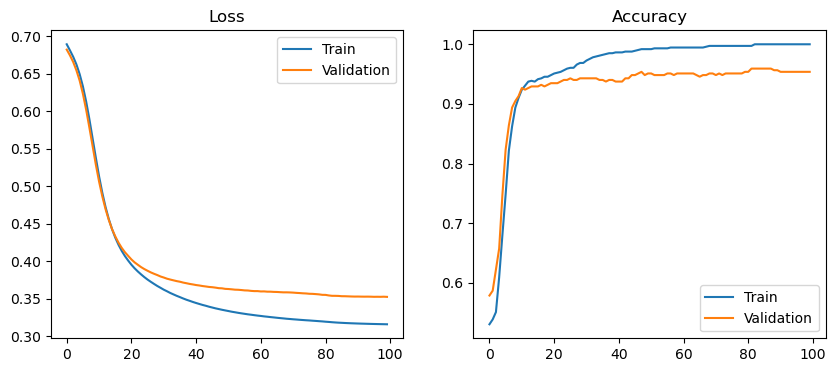

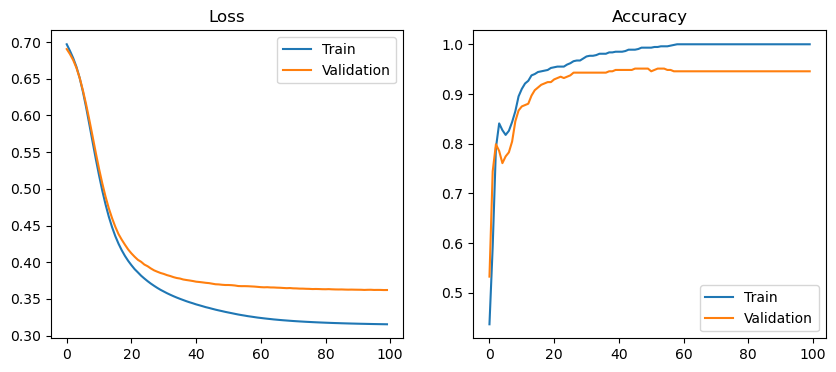

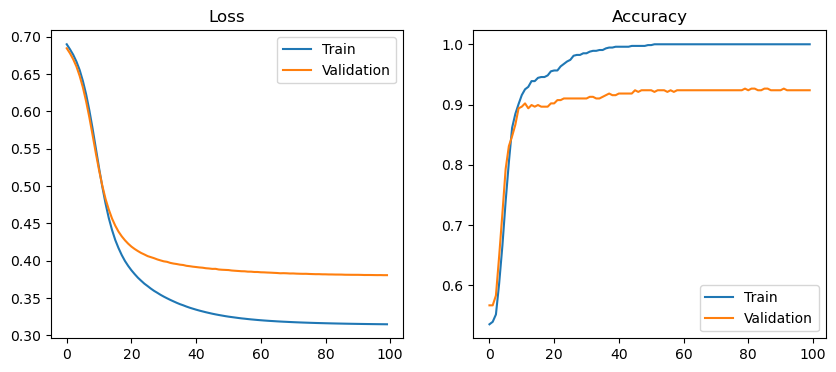

In [75]:
KFoldCrossValidation(WinPredictor, 3, X, y)

## Analysis: 
### 1. High variance/overfitting. Model is not learning underlying relationships.
### 2. Given team stats for every game, model predicts wins very well (i.e., much better than random chance). 

# Section 2: Creating rolling average and over/under prediction

In [76]:
#prepared stats for team1 and team2
br_df = pd.read_csv('br31.csv')
team1_stats = br_df.filter(regex='team1').rename(columns=lambda x: x.replace('team1_', ''))
team1_stats['team'] = br_df['team1']
team1_stats['date'] = br_df['date']

team2_stats = br_df.filter(regex='team2').rename(columns=lambda x: x.replace('team2_', ''))
team2_stats['team'] = br_df['team2']
team2_stats['date'] = br_df['date']

#concatenate and calculate cumulative stats
all_stats = pd.concat([team1_stats, team2_stats])
all_stats_grouped = all_stats.groupby(['team', 'date']).sum(numeric_only=True).groupby('team').cumsum()
all_stats_grouped['games_played'] = all_stats.groupby(['team', 'date']).size().groupby('team').cumsum()

#ensured indices are aligned properly
current_game_stats = all_stats.groupby(['team', 'date']).sum(numeric_only=True)
current_game_stats = current_game_stats.reindex(all_stats_grouped.index)

#calculated running averages by excluding current game stats
all_stats_grouped['games_played'] = all_stats_grouped['games_played'] - 1  # Decrement games played for current game stats exclusion
avg_stats_per_game = (all_stats_grouped - current_game_stats)
avg_stats_per_game = avg_stats_per_game.div(all_stats_grouped['games_played'], axis=0)  # Use division method to handle any misalignment

# Handle division by zero for the first game
avg_stats_per_game = avg_stats_per_game.replace([np.inf, -np.inf], np.nan).fillna(0)
avg_stats_per_game.reset_index(inplace=True)

print(avg_stats_per_game)


            team        date        FGA    FG_pct        FTA    FT_pct  \
0        Atlanta  2023-11-01   0.000000  0.000000   0.000000  0.000000   
1        Atlanta  2023-11-04  92.000000  0.500000  32.000000  0.906000   
2        Atlanta  2023-11-06  92.500000  0.492000  28.000000  0.849000   
3        Atlanta  2023-11-09  95.666667  0.452333  29.333333  0.847333   
4        Atlanta  2023-11-11  93.000000  0.459750  29.500000  0.827250   
...          ...         ...        ...       ...        ...       ...   
2201  Washington  2024-03-29  91.457143  0.471600  20.071429  0.762443   
2202  Washington  2024-03-31  91.408451  0.470718  19.901408  0.762268   
2203  Washington  2024-04-02  91.361111  0.470500  19.916667  0.762264   
2204  Washington  2024-04-03  91.383562  0.470973  19.876712  0.763110   
2205  Washington  2024-04-05  91.378378  0.471297  19.783784  0.765270   

            TOV        TRB        ast       blk   fg3_pct       fg3a  \
0      0.000000   0.000000   0.000000  

In [77]:
#loading original data
br_df = pd.read_csv('br31.csv')

#making sure date is in datetime format
br_df['date'] = pd.to_datetime(br_df['date'])
avg_stats_per_game['date'] = pd.to_datetime(avg_stats_per_game['date'])

#creating unique indentifiers for merging
br_df['team_date'] = br_df['team1'].astype(str) + '_' + br_df['date'].dt.strftime('%Y-%m-%d')
avg_stats_per_game['team_date'] = avg_stats_per_game['team'].astype(str) + '_' + avg_stats_per_game['date'].dt.strftime('%Y-%m-%d')

#renaming date to avoid conflict
avg_stats_per_game = avg_stats_per_game.rename(columns={'date': 'date_avg'})

# Rename columns in avg_stats_per_game for team1
avg_stats_per_game_team1 = avg_stats_per_game.rename(columns=lambda x: x + '_avg1' if x not in ['team_date', 'team', 'date_avg'] else x)

# Merge the average statistics with the game results for team1
br_df = pd.merge(br_df, avg_stats_per_game_team1, on='team_date', how='left')

# Restore original 'date' column
br_df['date_avg1'] = br_df['date_avg']
br_df.drop(columns=['date_avg'], inplace=True)

# Update the unique identifiers for merging team2 statistics
br_df['team_date'] = br_df['team2'].astype(str) + '_' + br_df['date'].dt.strftime('%Y-%m-%d')

# Rename columns in avg_stats_per_game for team2
avg_stats_per_game_team2 = avg_stats_per_game.rename(columns=lambda x: x + '_avg2' if x not in ['team_date', 'team', 'date_avg'] else x)

# Merge the average statistics with the game results for team2
br_df = pd.merge(br_df, avg_stats_per_game_team2, on='team_date', how='left')

# Restore original 'date' column for team2
br_df['date_avg2'] = br_df['date_avg']
br_df.drop(columns=['date_avg'], inplace=True)

# Clean up unnecessary columns
columns_to_keep = [
    'date', 'team1', 'team1_score', 'team2', 'team2_score', 'Home_Team_ID', 'Away_Team_ID', 'HomeWin', 'month',
    'FGA_avg1', 'FG_pct_avg1', 'FTA_avg1', 'FT_pct_avg1', 'TOV_avg1', 'TRB_avg1', 'ast_avg1', 'blk_avg1',
    'fg3_pct_avg1', 'fg3a_avg1', 'score_avg1', 'stl_avg1', 'FGA_avg2', 'FG_pct_avg2', 'FTA_avg2', 'FT_pct_avg2',
    'TOV_avg2', 'TRB_avg2', 'ast_avg2', 'blk_avg2', 'fg3_pct_avg2', 'fg3a_avg2', 'score_avg2', 'stl_avg2'
]
br_df = br_df[columns_to_keep]

#saved the final DataFrame
#br_df.to_csv('br33.csv', index=False)

print(br_df)


           date        team1  team1_score         team2  team2_score  \
0    2023-11-01   Washington          121       Atlanta          130   
1    2023-11-01      Indiana          104        Boston          155   
2    2023-11-01      Chicago          105        Dallas          114   
3    2023-11-01     Portland          110       Detroit          101   
4    2023-11-01   Sacramento          101  Golden State          102   
...         ...          ...          ...           ...          ...   
1098 2024-04-05      Detroit           90       Memphis          108   
1099 2024-04-05      Toronto          117     Milwaukee          111   
1100 2024-04-05  San Antonio          111   New Orleans          109   
1101 2024-04-05    Minnesota           87       Phoenix           97   
1102 2024-04-05     Portland          108    Washington          102   

      Home_Team_ID  Away_Team_ID  HomeWin  month   FGA_avg1  ...   FTA_avg2  \
0               22             0        1      0   0.000

# Over/Under Prediction With RandomForestClassifier and BR33 Dataframe That Uses Rolling Averages

In [78]:
br_df = pd.read_csv('br33.csv')
#dropping rows with 0s
br_df = br_df[(br_df['FGA_avg1'] != 0)
             ]
br_df = br_df.reset_index(drop = True)
threshold = 220
br_df['OverUnder'] = (br_df['team2_score'] + br_df['team1_score'] > threshold).astype(int) 
#astype coverts boolean to integer 0 and 1


print(br_df)
br_cool = br_df

            date        team1  team1_score         team2  team2_score  \
0     2023-11-02      Detroit          116   New Orleans          125   
1     2023-11-02      Toronto           99  Philadelphia          114   
2     2023-11-03     Brooklyn          109       Chicago          107   
3     2023-11-03       Dallas          114        Denver          125   
4     2023-11-03    Cleveland          116       Indiana          121   
...          ...          ...          ...           ...          ...   
1083  2024-04-05      Detroit           90       Memphis          108   
1084  2024-04-05      Toronto          117     Milwaukee          111   
1085  2024-04-05  San Antonio          111   New Orleans          109   
1086  2024-04-05    Minnesota           87       Phoenix           97   
1087  2024-04-05     Portland          108    Washington          102   

      Home_Team_ID  Away_Team_ID  HomeWin  month   FGA_avg1  ...  FT_pct_avg2  \
0               10            13        1 

In [79]:
numeric_data = br_df.drop(['date', 'month', 'team1_score', 'team2_score', 'OverUnder',
                           'HomeWin', 'team1', 'team2'], axis = 1).values


X = numeric_data

y = br_df['OverUnder'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [80]:
rf = RandomForestClassifier(random_state=42, n_jobs=-1)

params = {
    'max_depth': [2,3,5,10,20],
    'min_samples_leaf': [5,10,20,50,100,200],
    'n_estimators': [10,25,30,50,100,200]
}

from sklearn.model_selection import GridSearchCV

# Instantiate the grid search model
grid_search = GridSearchCV(estimator=rf,
                           param_grid=params,
                           cv = 4,
                           n_jobs=-1, verbose=1, scoring="accuracy")

grid_search.fit(X_train, y_train)

Fitting 4 folds for each of 180 candidates, totalling 720 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   11.4s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:   34.1s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 720 out of 720 | elapsed:  2.2min finished


GridSearchCV(cv=4, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=-1,
                                              oob_score=False, random_state=42,
                                    

In [81]:
print(grid_search.best_score_)
rf_best = grid_search.best_estimator_
print(rf_best)

0.6459909947998139
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=5, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=20, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)


In [82]:
# Instantiate the model
rf = RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=5, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=20, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=-1, oob_score=False, verbose=0,
                       warm_start=False)


# Train the model
rf.fit(X_train, y_train)

# Make predictions
y_pred = rf.predict(X_test)
#print(rf.oob_score_)
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

Accuracy: 0.6697247706422018


# With standard scaling and onehot encoding

In [83]:
cat = br_df[['Home_Team_ID', 'Away_Team_ID']].values
encoder = OneHotEncoder()
cat_ohe = encoder.fit_transform(cat).toarray()

numeric_data = br_df.drop(['date', 'month', 'team1_score', 'team2_score', 'OverUnder',
                           'Home_Team_ID', 'Away_Team_ID', 'HomeWin', 'team1', 'team2'], axis = 1).values
scaler = StandardScaler()
x_norm = scaler.fit_transform(numeric_data)
X = np.hstack((x_norm, cat_ohe))
print(X.shape)

y = br_df['OverUnder'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Instantiate the model
rf = RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=5, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=20, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=-1, oob_score=False, verbose=0,
                       warm_start=False)


# Train the model
rf.fit(X_train, y_train)

# Make predictions
y_pred = rf.predict(X_test)
#print(rf.oob_score_)
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

(1088, 84)
Accuracy: 0.6880733944954128


# Invidivual match prediction

In [84]:
br_df = pd.read_csv('br33.csv')
#dropping rows with 0s
br_df = br_df[(br_df['FGA_avg1'] != 0)
             ]
br_df = br_df.reset_index(drop = True)

print(br_df)
br_cool = br_df

            date        team1  team1_score         team2  team2_score  \
0     2023-11-02      Detroit          116   New Orleans          125   
1     2023-11-02      Toronto           99  Philadelphia          114   
2     2023-11-03     Brooklyn          109       Chicago          107   
3     2023-11-03       Dallas          114        Denver          125   
4     2023-11-03    Cleveland          116       Indiana          121   
...          ...          ...          ...           ...          ...   
1083  2024-04-05      Detroit           90       Memphis          108   
1084  2024-04-05      Toronto          117     Milwaukee          111   
1085  2024-04-05  San Antonio          111   New Orleans          109   
1086  2024-04-05    Minnesota           87       Phoenix           97   
1087  2024-04-05     Portland          108    Washington          102   

      Home_Team_ID  Away_Team_ID  HomeWin  month   FGA_avg1  ...   FTA_avg2  \
0               10            13        1   

# With OHE and Standard Scaling

In [59]:
team_names = {
  0: 'Washington',
  1: 'Indiana',
  2: 'Chicago',
  3: 'Portland',
  4: 'Sacramento',
  5: 'Charlotte',
  6: 'LA Clippers',
  7: 'Brooklyn',
  8: 'Denver',
  9: 'Cleveland',
  10: 'New Orleans',
  11: 'Milwaukee',
  12: 'Memphis',
  13: 'Detroit',
  14: 'Toronto',
  15: 'San Antonio',
  16: 'Orlando',
  17: 'Dallas',
  18: 'New York',
  19: 'Golden State',
  20: 'Boston',
  21: 'Utah',
  22: 'Atlanta',
  23: 'LA Lakers',
  24: 'Phoenix',
  25: 'Miami',
  26: 'Philadelphia',
  27: 'Oklahoma City',
  28: 'Minnesota',
  29: 'Houston'
}

def prepare_features(home_stats, away_stats):
    """
    Prepares the numeric feature vector from home and away team stats.
    Uses suffixes '_1' for home team stats and '_2' for away team stats as per the dataset.
    """
    #stats list for home and away teams as per suffix conventions
    home_stats_list = [
        'FGA_avg1', 'FG_pct_avg1', 'FTA_avg1', 'FT_pct_avg1', 'TOV_avg1',
        'TRB_avg1', 'ast_avg1', 'blk_avg1', 'fg3_pct_avg1', 'fg3a_avg1',
        'score_avg1', 'stl_avg1'
    ]
    away_stats_list = [
        'FGA_avg2', 'FG_pct_avg2', 'FTA_avg2', 'FT_pct_avg2', 'TOV_avg2',
        'TRB_avg2', 'ast_avg2', 'blk_avg2', 'fg3_pct_avg2', 'fg3a_avg2',
        'score_avg2', 'stl_avg2'
    ]

    #extract the respective stats for home and away teams
    home_features = home_stats[home_stats_list].values.flatten()
    away_features = away_stats[away_stats_list].values.flatten()

    #combine home and away features
    return np.hstack([home_features, away_features])

def get_latest_team_stats(team_stats_df, team_id, home = None):
    """
    Retrieves the latest stats for a given team_id based on the most recent date.
    """
    if home is not None:
        team_data = team_stats_df[team_stats_df['Home_Team_ID'] == team_id]
        latest_entry = team_data.sort_values(by='date', ascending=False).iloc[0]
    else:
        team_data = team_stats_df[team_stats_df['Away_Team_ID'] == team_id]
        latest_entry = team_data.sort_values(by='date', ascending=False).iloc[0]
    return latest_entry

def predict_tomorrow_games(matchups, team_stats_df, thresholds):
    predictions = []
    
    all_team_ids = np.unique(team_stats_df[['Home_Team_ID', 'Away_Team_ID']].values.flatten())
    encoder = OneHotEncoder(categories=[all_team_ids, all_team_ids])
    scaler = StandardScaler()

    #preparing the numeric data for scaling and categorical data for encoding
    numeric_columns = team_stats_df.drop(['date',
                                          'month',
                                          'team1_score', 
                                          'team2_score',  
                                          'Home_Team_ID', 
                                          'Away_Team_ID', 
                                          'HomeWin', 
                                          'team1', 
                                          'team2'], axis = 1).values
    x_norm = scaler.fit_transform(numeric_columns)
    cat = team_stats_df[['Home_Team_ID', 'Away_Team_ID']].values
    cat_ohe = encoder.fit_transform(cat).toarray()
    X = np.hstack((x_norm, cat_ohe))  # Full feature set for training
    
    

    for index, (home_id, away_id) in enumerate(matchups):
        threshold = thresholds[index]
        probabilities_list = []
        accuracy_list = []
        team_stats_df2 = team_stats_df.copy(deep=True)
        
        for _ in range(20):
            
            team_stats_df2['OverUnder'] = (team_stats_df['team2_score'] + team_stats_df['team1_score'] > threshold).astype(int)
            y = team_stats_df2['OverUnder'].values
            
            #split data for training and testing
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
            rf = RandomForestClassifier(n_estimators=200)
            rf.fit(X_train, y_train)
            y_pred = rf.predict(X_test)
            accuracy = accuracy_score(y_test, y_pred)
            accuracy_list.append(accuracy)
            
            # prepare features for prediction for the current game
            home_stats = get_latest_team_stats(team_stats_df2, home_id, home=True)
            away_stats = get_latest_team_stats(team_stats_df2, away_id, home=None)
            numeric_features = prepare_features(home_stats, away_stats)
            numeric_features = scaler.fit_transform(numeric_features.reshape(1, -1))
            categorical_features = np.array([[home_id, away_id]])
            encoded_features = encoder.transform(categorical_features).toarray()
            
            game_features = np.hstack((encoded_features, numeric_features))
            
            # Predict probabilities and store them
            probabilities = rf.predict_proba(game_features)[0, 1]
            probabilities_list.append(probabilities)

        #average the probabilities and accuracies for current matchup
        avg_probability = np.mean(probabilities_list)
        avg_accuracy = np.mean(accuracy_list)
        final_decision = "Over" if avg_probability > 0.5 else "Under"
        confidence = "High Confidence" if avg_probability >= 0.60 or avg_probability <= 0.40 else "Low Confidence"
        
        predictions.append((team_names[home_id], team_names[away_id], round(avg_accuracy, 3), threshold, round(avg_probability, 3), final_decision, confidence))
    
    return predictions



In [60]:
#march 20 to 21st ish 2023
# 12 correct and only 1 wrong
#WOW!

matchup = [(25, 2), (10, 4), (28, 2)] # Home team is (HERE, NOT HERE)
threshold = [207, 210, 200]


predict_tomorrow_games(matchups=matchup, 
                       team_stats_df=br_cool, 
                       thresholds=threshold)


[('Miami', 'Chicago', 0.858, 207, 0.944, 'Over', 'High Confidence'),
 ('New Orleans', 'Sacramento', 0.807, 210, 0.824, 'Over', 'High Confidence'),
 ('Minnesota', 'Chicago', 0.932, 200, 0.986, 'Over', 'High Confidence')]

# Without Standard Scaling and One Hot Encoding

In [57]:
team_names = {
    0: 'Washington', 1: 'Indiana', 2: 'Chicago', 3: 'Portland', 4: 'Sacramento',
    5: 'Charlotte', 6: 'LA Clippers', 7: 'Brooklyn', 8: 'Denver', 9: 'Cleveland',
    10: 'New Orleans', 11: 'Milwaukee', 12: 'Memphis', 13: 'Detroit', 14: 'Toronto',
    15: 'San Antonio', 16: 'Orlando', 17: 'Dallas', 18: 'New York', 19: 'Golden State',
    20: 'Boston', 21: 'Utah', 22: 'Atlanta', 23: 'LA Lakers', 24: 'Phoenix', 25: 'Miami',
    26: 'Philadelphia', 27: 'Oklahoma City', 28: 'Minnesota', 29: 'Houston'
}

def prepare_features(home_stats, away_stats):
    """
    Prepares the numeric feature vector from home and away team stats.
    Uses suffixes '_avg1' for home team stats and '_avg2' for away team stats as per the dataset.
    """
    
    home_stats_list = [
        'FGA_avg1', 'FG_pct_avg1', 'FTA_avg1', 'FT_pct_avg1', 'TOV_avg1',
        'TRB_avg1', 'ast_avg1', 'blk_avg1', 'fg3_pct_avg1', 'fg3a_avg1',
        'score_avg1', 'stl_avg1'
    ]
    away_stats_list = [
        'FGA_avg2', 'FG_pct_avg2', 'FTA_avg2', 'FT_pct_avg2', 'TOV_avg2',
        'TRB_avg2', 'ast_avg2', 'blk_avg2', 'fg3_pct_avg2', 'fg3a_avg2',
        'score_avg2', 'stl_avg2'
    ]

   
    home_features = home_stats[home_stats_list].values.flatten()
    away_features = away_stats[away_stats_list].values.flatten()

   
    return np.hstack([home_features, away_features])

def get_latest_team_stats(team_stats_df, team_id, home=None):
    """
    Retrieves the latest stats for a given team_id based on the most recent date.
    """
    if home:
        team_data = team_stats_df[team_stats_df['Home_Team_ID'] == team_id]
    else:
        team_data = team_stats_df[team_stats_df['Away_Team_ID'] == team_id]

    latest_entry = team_data.sort_values(by='date', ascending=False).iloc[0]
    return latest_entry

def predict_tomorrow_games(matchups, team_stats_df, thresholds):
    predictions = []

    for index, (home_id, away_id) in enumerate(matchups):
        threshold = thresholds[index]
        probabilities_list = []
        accuracy_list = []

        team_stats_df2 = team_stats_df.copy(deep=True)
        for _ in range(20):
            team_stats_df2['OverUnder'] = (team_stats_df2['team2_score'] + team_stats_df2['team1_score'] > threshold).astype(int)
            y = team_stats_df2['OverUnder'].values

            # Prepare numeric features and categorical team IDs for training
            numeric_columns = team_stats_df2.drop(columns=['date', 'month', 'team1_score', 'team2_score', 'Home_Team_ID', 'Away_Team_ID', 'HomeWin', 'team1', 'team2', 'OverUnder'])
            X_numeric = numeric_columns.values
            X_team_ids = team_stats_df2[['Home_Team_ID', 'Away_Team_ID']].values
            X = np.hstack((X_numeric, X_team_ids))

            
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
            rf = RandomForestClassifier(n_estimators=200, random_state=42)
            rf.fit(X_train, y_train)
            y_pred = rf.predict(X_test)
            accuracy = accuracy_score(y_test, y_pred)
            accuracy_list.append(accuracy)

           
            home_stats = get_latest_team_stats(team_stats_df2, home_id, home=True)
            away_stats = get_latest_team_stats(team_stats_df2, away_id, home=False)
            numeric_features = prepare_features(home_stats, away_stats)
            game_features = np.hstack((numeric_features, [home_id, away_id])).reshape(1, -1)

            
            probabilities = rf.predict_proba(game_features)[0, 1]
            probabilities_list.append(probabilities)

      
        avg_probability = np.mean(probabilities_list)
        avg_accuracy = np.mean(accuracy_list)
        final_decision = "Over" if avg_probability > 0.5 else "Under"
        confidence = "High Confidence" if avg_probability >= 0.60 or avg_probability <= 0.40 else "Low Confidence"

        predictions.append((team_names[home_id], team_names[away_id], round(avg_accuracy, 3), threshold, round(avg_probability, 3), final_decision, confidence))

    return predictions


In [58]:
matchup = [(25, 2), (10, 4), (28, 2)] # Home team is (HERE, NOT HERE)
threshold = [207, 210, 200]


predict_tomorrow_games(matchups=matchup, 
                       team_stats_df=br_cool, 
                       thresholds=threshold)


[('Miami', 'Chicago', 0.86, 207, 0.815, 'Over', 'High Confidence'),
 ('New Orleans', 'Sacramento', 0.812, 210, 0.65, 'Over', 'High Confidence'),
 ('Minnesota', 'Chicago', 0.934, 200, 0.895, 'Over', 'High Confidence')]